In [25]:
%pip install glom transformers datasets bitsandbytes accelerate peft hf_transfer matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 54.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 188.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 11.4 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=188930485 sha256=f242b686e89e4bd88474ac4ceb7a5b19d738b4e63e2132f50edd7b6f397f8654
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash-attn

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

os.environ['HF_HOME'] = '/workspace/.hf'
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_ID = "Qwen/Qwen2-1.5B"
CODE_MODEL_ID = "Replete-AI/Replete-Coder-Qwen2-1.5b"
GERMAN_MODEL_ID = "VAGOsolutions/SauerkrautLM-1.5b"

base_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.bfloat16, use_flash_attention_2=True, device_map="auto")
code_model = AutoModelForCausalLM.from_pretrained(CODE_MODEL_ID, torch_dtype=torch.bfloat16, use_flash_attention_2=True, device_map="auto")
german_model = AutoModelForCausalLM.from_pretrained(GERMAN_MODEL_ID, torch_dtype=torch.bfloat16, use_flash_attention_2=True, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.


In [3]:
import os
import torch
import torch
import bitsandbytes as bnb
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
from peft.tuners.lora import QuantLinear


def get_linear_embedding_layers(model_type):
    """
    returns the linear embedding layers needed for loras, dependent on the model arch
    """
    if model_type == "gpt_neox":
        return ["embed_in", "embed_out"]
    if model_type == "falcon":
        return ["word_embeddings", "lm_head"]
    return ["embed_tokens", "lm_head"]


def find_all_linear_names(model):
    cls = (bnb.nn.Linear4bit, bnb.nn.Linear8bitLt, torch.nn.Linear, QuantLinear)

    names = []
    for name, module in model.named_modules():
        if (
            isinstance(module, cls)
            or "Linear" in module.__class__.__name__
            and module.__class__.__name__ not in ("LlamaLinearScalingRotaryEmbedding",)
        ):
            names.append(name)


    return names

In [4]:
modules = find_all_linear_names(base_model)

In [5]:
def compute_ziplora_loss_for_lm(model, content_prompt, style_prompt, lambda_coef=0.01, temperature=2.0):
    # Tokenize inputs
    batch = tokenizer([content_prompt, style_prompt], padding="max_length", truncation=True, max_length=4096, return_tensors='pt')

    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)

    # Split inputs for code and German
    code_input = input_ids[0].to(model.device)
    german_input = input_ids[1].to(model.device)

    # Prepare labels (shifted input_ids)
    labels = batch["input_ids"].clone()
    labels[attention_mask == 0] = -100  # Set padding token positions to -100

    code_labels = labels[0].to(model.device)
    german_labels = labels[1].to(model.device)

    with torch.no_grad():
        # Get logits from code model
        for module in model.modules():
            if isinstance(module, ZipLoRALinearLayer):
                module.set_forward_type('weight_1')
        original_code_logits = model(input_ids=code_input.unsqueeze(0), labels=code_labels.unsqueeze(0)).logits

        # Get logits from German model
        for module in model.modules():
            if isinstance(module, ZipLoRALinearLayer):
                module.set_forward_type('weight_2')
        original_german_logits = model(input_ids=german_input.unsqueeze(0), labels=german_labels.unsqueeze(0)).logits

    # Set model to merged mode
    for module in model.modules():
        if isinstance(module, ZipLoRALinearLayer):
            module.set_forward_type('merge')   

    # Get logits from merged model for both inputs
    merged_code_logits = model(input_ids=code_input.unsqueeze(0), labels=code_labels.unsqueeze(0)).logits
    merged_german_logits = model(input_ids=german_input.unsqueeze(0), labels=german_labels.unsqueeze(0)).logits

    # Calculate content loss (KL divergence between merged and original code logits)
    content_loss = F.kl_div(
        F.log_softmax(merged_code_logits / temperature, dim=-1),
        F.softmax(original_code_logits / temperature, dim=-1),
        reduction='batchmean'
    ) * (temperature ** 2) / len(code_input)
    
    # Calculate style loss (KL divergence between merged and original German logits)
    style_loss = F.kl_div(
        F.log_softmax(merged_german_logits / temperature, dim=-1),
        F.softmax(original_german_logits / temperature, dim=-1),
        reduction='batchmean'
    ) * (temperature ** 2) / len(german_input)
    
    # Calculate similarity loss to encourage diversity between mergers
    similarity_loss = 0.0
    for module in base_model.modules():
        if isinstance(module, ZipLoRALinearLayer):
            similarity_loss += module.compute_mergers_similarity()
    
    # Combine losses
    total_loss = content_loss + style_loss + lambda_coef * similarity_loss

    return total_loss

In [6]:
from tqdm import tqdm
from glom import glom, Assign

for m in tqdm(modules):
    linear_a = glom(code_model, m)
    linear_b = glom(german_model, m)
    
    zipped = ZipLoRALinearLayer(
        linear_a=linear_a,
        linear_b=linear_b,
        init_merger_value=0.5,
        init_merger_value_2=0.5,
        device=base_model.device,
        dtype=linear_a.weight.dtype
    )

    assign = Assign(m, zipped)
    glom(base_model, assign)

100%|██████████| 197/197 [00:00<00:00, 1857.35it/s]


In [7]:
import gc
code_model.cpu()
german_model.cpu()

del code_model, german_model
gc.collect()
torch.cuda.empty_cache()

In [8]:
from transformers import pipeline

generator = pipeline(model=base_model, task='text-generation', tokenizer=tokenizer)
generator([{"role": "user", "content": "Who is the most famous president in history?"}], do_sample=True, max_new_tokens=64)[0]['generated_text'][-1]['content']

"Many consider Washington D.C.'s George Washington as the most famous president in history due to his influential role during the American Revolution and his successful leadership of the First Continental Congress that laid the foundation of independence from Great Britain. He also achieved significant diplomatic tasks and is often considered father of the United States.\nWhile this"

In [9]:
from datasets import load_dataset

code_dataset = load_dataset("HuggingFaceH4/CodeAlpaca_20K")

In [10]:
templated_code_dataset = code_dataset.map(lambda row: {'text' : tokenizer.apply_chat_template([{'role': 'user', 'content': row['prompt']}, {'role': 'assistant', 'content': row['completion'] }], tokenize=False).strip()})

In [11]:
from datasets import load_dataset

german_dataset = load_dataset("bjoernp/ultrachat_de")

In [12]:
def convert_sharegpt(convo):
    role_map = {'system': 'system', 'human': 'user', 'gpt': 'assistant'}
    return [{'role': role_map[e['from']], 'content': e['value']} for e in convo]

In [13]:
templated_german_dataset = german_dataset.map(lambda row: {'text' : tokenizer.apply_chat_template(convert_sharegpt(row['conversations']), tokenize=False).strip()})

In [14]:
def compute_ziplora_loss_for_lm(model, content_prompt, style_prompt, lambda_coef=0.01, temperature=2.0):
    # Tokenize inputs
    batch = tokenizer([content_prompt, style_prompt], padding="max_length", truncation=True, max_length=4096, return_tensors='pt')

    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)

    # Split inputs for code and German
    code_input = input_ids[0].to(model.device)
    german_input = input_ids[1].to(model.device)

    # Prepare labels (shifted input_ids)
    labels = batch["input_ids"].clone()
    labels[attention_mask == 0] = -100  # Set padding token positions to -100

    code_labels = labels[0].to(model.device)
    german_labels = labels[1].to(model.device)

    with torch.no_grad():
        # Get logits from model_A (code model)
        for module in model.modules():
            if isinstance(module, ZipLoRALinearLayer):
                module.set_forward_type('weight_1')
        original_code_logits = model(input_ids=code_input.unsqueeze(0), labels=code_labels.unsqueeze(0)).logits

        # Get logits from model_B (German model)
        for module in model.modules():
            if isinstance(module, ZipLoRALinearLayer):
                module.set_forward_type('weight_2')
        original_german_logits = model(input_ids=german_input.unsqueeze(0), labels=german_labels.unsqueeze(0)).logits

    # Set model to merged mode
    for module in model.modules():
        if isinstance(module, ZipLoRALinearLayer):
            module.set_forward_type('merge')   

    # Get logits from merged model for both inputs
    merged_code_logits = model(input_ids=code_input.unsqueeze(0), labels=code_labels.unsqueeze(0)).logits
    merged_german_logits = model(input_ids=german_input.unsqueeze(0), labels=german_labels.unsqueeze(0)).logits

    # Calculate content loss (KL divergence between merged and original code logits)
    content_loss = F.kl_div(
        F.log_softmax(merged_code_logits / temperature, dim=-1),
        F.softmax(original_code_logits / temperature, dim=-1),
        reduction='batchmean'
    ) * (temperature ** 2) / len(code_input)
    
    # Calculate style loss (KL divergence between merged and original German logits)
    style_loss = F.kl_div(
        F.log_softmax(merged_german_logits / temperature, dim=-1),
        F.softmax(original_german_logits / temperature, dim=-1),
        reduction='batchmean'
    ) * (temperature ** 2) / len(german_input)
    
    # Calculate similarity loss to encourage diversity between mergers
    similarity_loss = 0.0
    for module in base_model.modules():
        if isinstance(module, ZipLoRALinearLayer):
            similarity_loss += module.compute_mergers_similarity()
    
    # Combine losses
    total_loss = content_loss + style_loss + lambda_coef * similarity_loss

    return total_loss

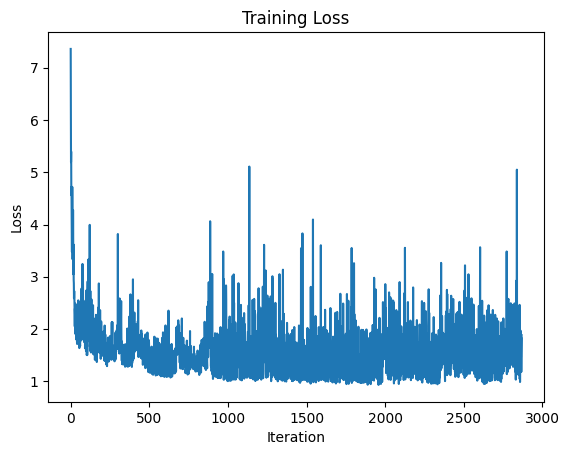

Epoch 3/3: 100%|██████████| 959/959 [17:51<00:00,  1.12s/it, loss=1.6146]

Epoch 3/3, Average Loss: 1.5525


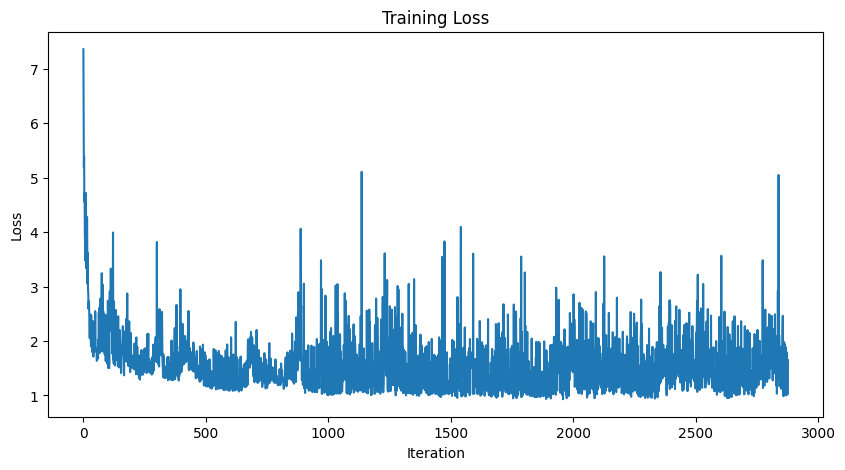

In [15]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

optimizer = torch.optim.AdamW(base_model.parameters(), lr=1e-3)

num_epochs = 1

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
losses = []

for epoch in range(num_epochs):
    base_model.train()
    total_loss = 0
    
    progress_bar = tqdm(zip(random.sample(templated_code_dataset['train']['text'], len(templated_code_dataset['train']['text'])), random.sample(templated_german_dataset['train']['text'], len(templated_german_dataset['train']['text']))), 
                        total=min([len(templated_code_dataset['train']['text']), len(templated_german_dataset['train']['text'])]),
                        desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (sql, de) in enumerate(progress_bar):
        loss = compute_ziplora_loss_for_lm(base_model, sql, de)

        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        current_loss = loss.item()
        total_loss += current_loss
        losses.append(current_loss)

        progress_bar.set_postfix({'loss': f'{current_loss:.4f}'})

        if i % 10 == 0:
            clear_output(wait=True)
            plt.clf()
            plt.plot(losses)
            plt.title("Training Loss")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()
    
    avg_loss = total_loss / len(progress_bar)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

plt.figure(figsize=(10,5))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [16]:
import torch
from transformers import AutoModelForCausalLM
from tqdm import tqdm

# Create a new model instance with the same architecture as the base model
new_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.bfloat16)

# Iterate through all modules and update weights for ZipLoRALinearLayers
for (name, module), (_, new_module) in tqdm(zip(base_model.named_modules(), new_model.named_modules()), 
                                            desc="Merging layers"):
    if isinstance(module, ZipLoRALinearLayer):
        # Get the merged weight and bias
        merged_weight = module.get_ziplora_weight()
        merged_bias = module.get_ziplora_bias()
        
        # Update the weights and bias of the corresponding layer in the new model
        new_module.weight.data = merged_weight
        if merged_bias is not None:
            new_module.bias.data = merged_bias

# Save the new model
new_model.save_pretrained("/workspace/zip_merged")
tokenizer.save_pretrained("/workspace/zip_merged")

print("Merged model saved successfully!")

Merging layers: 398it [00:00, 10245.20it/s]


Merged model saved successfully!
